# Solving Mixed Univariate Gaussian Models Using EM and Gibb's Sampler

In [38]:
library(tidyverse)
library(gridExtra)
library(invgamma)
library(gtools)

We start off by defining our mixture of 2 univariate normal densities as follows:

\begin{align*}
p(y;\theta) & = \pi\phi(y;\mu_1,\sigma_1) + (1-\pi)\phi(y;\mu_2,\sigma_2)
\end{align*}

Consider the case where $\pi = .4, \mu_1 = 9, \sigma_1 = 1, \mu_2 = 15, \sigma_2 = 2$

In [48]:

p <- 0.4
mu_1 <- 9
mu_2 <- 15
sigma_1 <- 1
sigma_2 <- 2
n = 200

First we'll define out parameters and generate some synthetic data.

In [51]:
f <- function(mu_1, mu_2, sigma_1, sigma_2, p, n) {
  groups <- rbinom(n = n, size = 1, prob = p)
  
  df <- data.frame(group = groups) %>%
    rowwise() %>%
    mutate(y = if_else(group == 0, 
                       rnorm(n = 1, mean = mu_1, sd = sqrt(sigma_1)), 
                       rnorm(n = 1, mean = mu_2, sd = sqrt(sigma_2))))
  
  return(df$y)
  
}

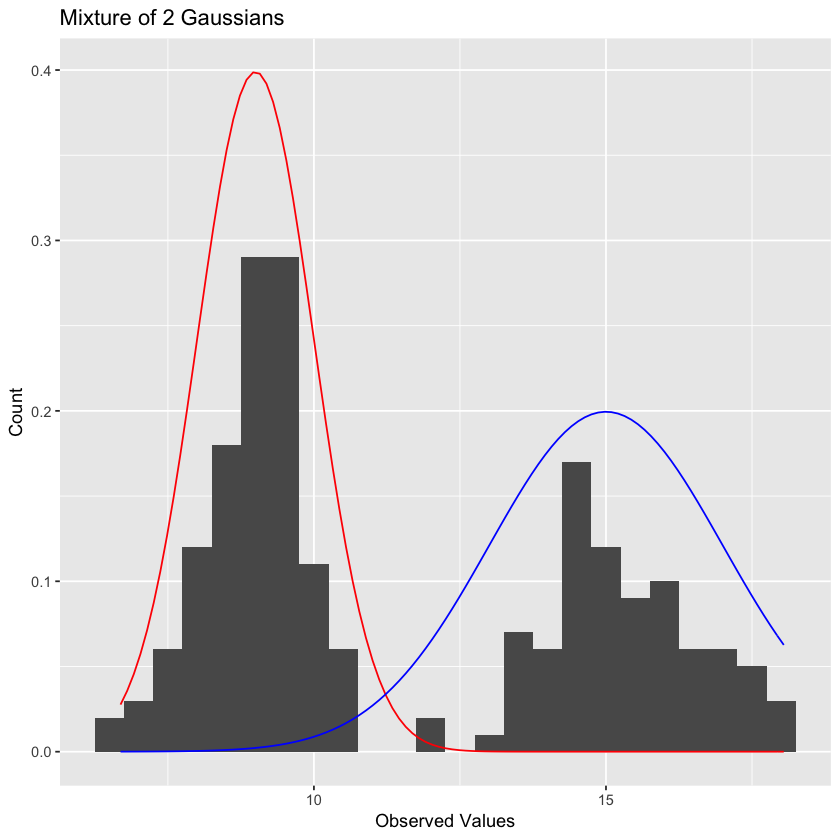

In [49]:
df <- data.frame(y = f(mu_1, mu_2, sigma_1, sigma_2, p, n))
df %>%
  ggplot(aes(x = y)) + geom_histogram(aes(y = stat(density)),binwidth = .5) + 
  ggtitle("Mixture of 2 Gaussians") + 
  xlab("Observed Values") + ylab("Count") + 
  stat_function(fun = dnorm, args = list(mean = 9, sd = 1), col="red") + 
  stat_function(fun = dnorm, args = list(mean = 15, sd = 2), col="blue")

## Using The EM Algorithm

To fit the EM Algorithm, we first initialize $\Theta$ as $(\pi = .7, \mu_1 = 10, \sigma_1 = 5, \mu_2 = 11, \sigma_2 = 5)$. We can play with different starting points if desired. We could also assume some prior to sample from for a starting point. 

### E Step

For the Expectation Step we solve for $Pr\left[Z=1|y;\theta^{(k)}\right]$ using Bayes Rule.

\begin{align*}
Pr\left[Z=1|y_i;\theta^{(k)}\right] & = \frac{\pi^k\phi(y_i;\mu_1^k,\sigma_1^k)}{\pi^k\phi(y_i;\mu_1^k,\sigma_1^k) + (1-\pi^k)\phi(y_i;\mu_2^k,\sigma_2^k)}\\
& = \gamma_i^k
\end{align*}

### M Step
Then for the maximization step we update our parameters as follows:

\begin{align*}
\mu_1^{(k+1)} & = \frac{\sum_{i=1}^n\gamma_i^ky_i}{\sum_{i=1}^n\gamma_i^k}\\
\\
\mu_2^{(k+1)} & = \frac{\sum_{i=1}^n(1-\gamma_i^k)y_i}{\sum_{i=1}^n(1-\gamma_i^k)}\\
\\
\sigma_1^{(k+1)} & = \frac{\sum_{i=1}^n\gamma_i^k(y_i-\mu_1^k)^2}{\sum_{i=1}^n\gamma_i^k}\\
\\
\sigma_2^{(k+1)} & = \frac{\sum_{i=1}^n(1-\gamma_i^k)(y_i-\mu_2^k)^2}{\sum_{i=1}^n(1-\gamma_i^k)}
\end{align*}

We can also plot the log-likelihood as a function of iterations where the log-likelihood function for our mixture model is defined as:

\begin{align*}
\ell(\theta) & = \sum_{i=1}^N\left[z_{1i}log(1-\pi) + z_{2i}log(\pi)\right] + \sum_{i=1}^N\left[z_{1i}\phi(y_i) + z_{2i}\phi(y_i)\right]
\end{align*}



pi 0.6444156 
mu_1 9.131245 
sigma_1 1.192014 
mu_2 15.18484 
sigma_2 2.279989

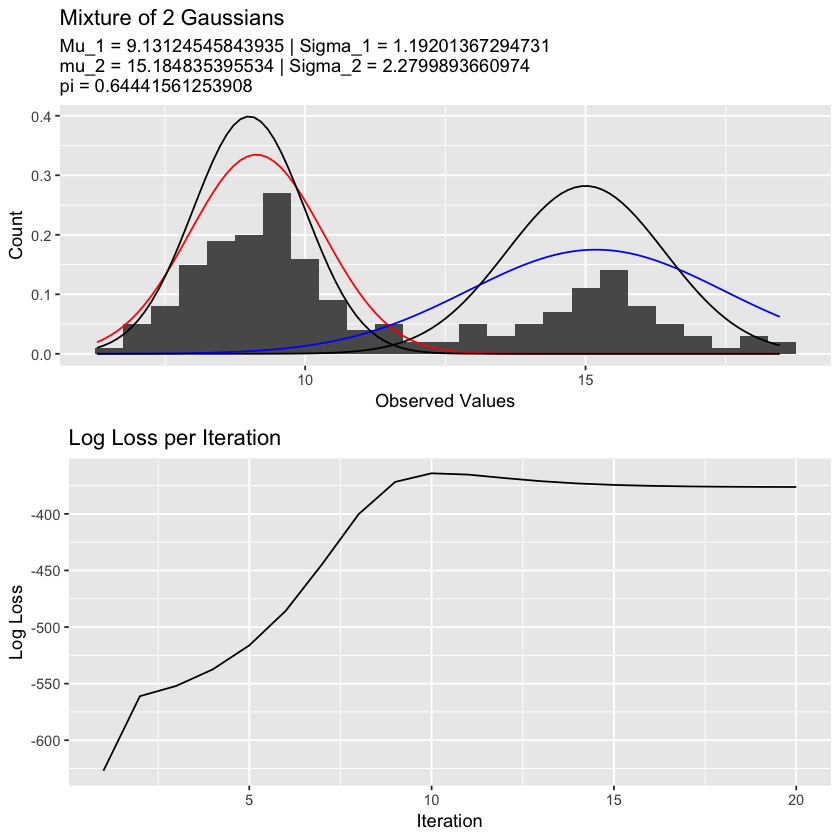

In [29]:
em_simple <- function(data, iters) {
  
  # setting our initial values for theta
  pi_i <- .7
  mu_1 <- 10
  mu_2 <- 11
  sigma_1 <- 5
  sigma_2 <- 5

  log_loss <- vector("numeric", length = iters)
    
  for (k in 1:iters) {
    
    # E - Step
    p_a <- vector("numeric", length = nrow(data))
    p_b <- vector("numeric", length = nrow(data))
    log_loss_i <- vector("numeric", length = nrow(data))
    
    for(i in 1:nrow(data)) { 
      y_a <- dnorm(data$y[i], mu_1, sqrt(sigma_1))
      y_b <- dnorm(data$y[i], mu_2, sqrt(sigma_2))
      
      p_a[i] <- pi_i*y_a / (pi_i*y_a + (1 - pi_i)*y_b)
      p_b[i] <- 1 - p_a[i]
        
      # Loss per data point
      log_loss_i[i] <- p_a[i]*log(1-pi_i) +  p_b[i]*log(pi) + 
                       p_a[i]*log(y_a) + p_b[i]*log(y_b)
    }
    
    # M - Step
    pi_i <- mean(p_a)
    
    sigma_1 <- sum(p_a * ((data$y - mu_1)^2)) / sum(p_a)
    sigma_2 <- sum(p_b * ((data$y - mu_2)^2)) / sum(p_b)
    
    mu_1 <- sum(p_a * data$y) / sum(p_a)
    mu_2 <- sum(p_b * data$y) / sum(p_b)
      
    # Sumed loss per iteration
    log_loss[k] <- sum(log_loss_i)
    
  }
  
  # Print out values for theta
  cat("\n\npi", pi_i, 
      "\nmu_1", mu_1, 
      "\nsigma_1", sigma_1, 
      "\nmu_2", mu_2, 
      "\nsigma_2", sigma_2)
  
  # Create plot with fitted parameters
  p_1 <- data %>%
    ggplot(aes(x = y)) + geom_histogram(aes(y = stat(density)),binwidth = .5) + 
    ggtitle("Mixture of 2 Gaussians", 
            subtitle = glue::glue("Mu_1 = {mu_1} | Sigma_1 = {sigma_1}
                                   mu_2 = {mu_2} | Sigma_2 = {sigma_2}
                                   pi = {pi_i}")) + 
    xlab("Observed Values") + ylab("Count") + 
    stat_function(fun = dnorm, args = list(mean = mu_1, sd = sigma_1), col="red") + 
    stat_function(fun = dnorm, args = list(mean = mu_2, sd = sigma_2), col="blue") +
    stat_function(fun = dnorm, args = list(mean = 9, sd = 1), col = "black") + 
    stat_function(fun = dnorm, args = list(mean = 15, sd = sqrt(2)), col = "black")
    
  p_2 <- data.frame(log_loss = log_loss, k = 1:iters) %>%
    ggplot(aes(x = k, y = log_loss)) + geom_line() + 
    ggtitle("Log Loss per Iteration") + 
    xlab("Iteration") + 
    ylab("Log Loss")
    
  grid.arrange(p_1, p_2, nrow = 2)
  
}

em_simple(df, 20)

## Using Gibb's Sampler

Whenever we can explicitly define the conditional distributions w.r.t. our parameters, we can use Gibb's Sampling to estimate those parameter valaues. To start we set our prior distributions as follows:

\begin{align*}
p(\pi) & \sim Be(1,1)\\
p(\mu) & \sim N(0,1)\\
p(\sigma) & \sim IG(1,1)
\end{align*}

Which leads to the conditional posterior distributions:

\begin{align*}
p(\pi | y,\mu,\sigma,z) & \sim Be(1 + n_j, 1 + (N - n_j))\\
p(z | y_i, \pi, \mu,\sigma) & \sim Cat(\pi_1,\pi_2)\\
p(\mu_j | z, \mu,\sigma) & \sim N\left(\frac{n_j\bar{x}_j}{1 +n_j}, \frac{\sigma_j}{1+n_j}\right)\\
p(\sigma_j |z, \pi, \mu) & \sim IG\left(1 + \frac{n_j}{2}, 1 + \frac{(y_i - \mu_j)^2}{2}\right)
\end{align*}



pi 0.6289495 
mu_1 8.840372 
sigma_1 1.009238 
mu_2 15.03646 
sigma_2 2.089658

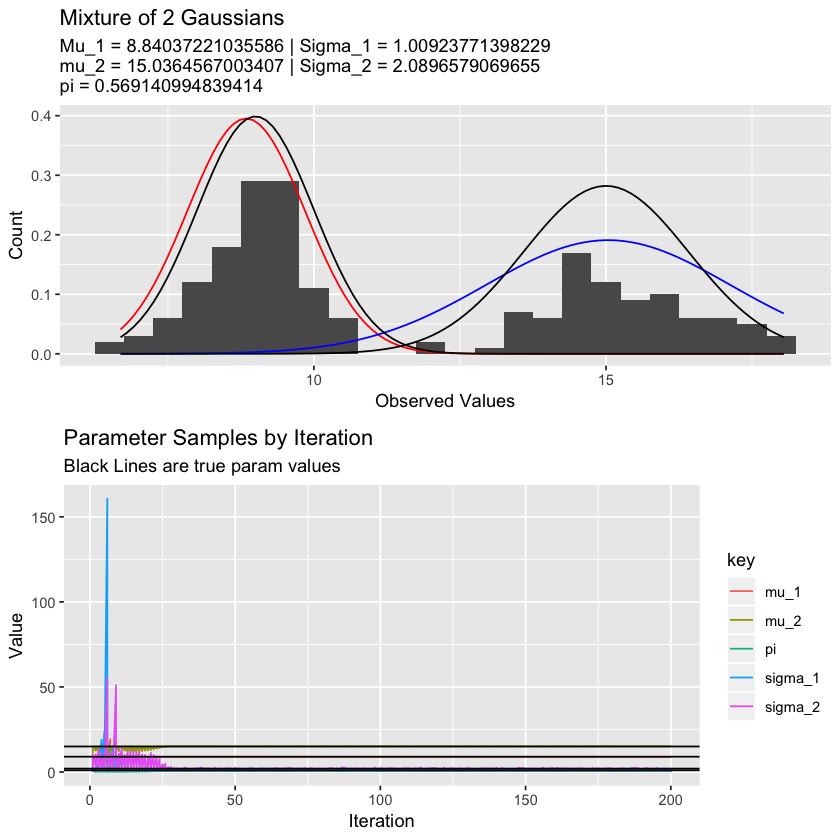

In [61]:
gibbs <- function(data, iters) {
  
  # Set initial using Prior Distributions
  pi_i <- rbeta(1,1,1)
  mu_1 <- rnorm(1,0,1)
  mu_2 <- rnorm(1,0,1)
  sigma_1 <- rinvgamma(1,1,1)
  sigma_2 <- rinvgamma(1,1,1)
  
  sigma_1_vec <- vector("numeric", length = nrow(data))
  sigma_2_vec <- vector("numeric", length = nrow(data))
  mu_1_vec <- vector("numeric", length = nrow(data))
  mu_2_vec <- vector("numeric", length = nrow(data))
  pi_vec <- vector("numeric", length = nrow(data))
  
  for (k in 1:iters) {
    
    p_a <- vector("numeric", length = nrow(data))
    z <- vector("numeric", length = nrow(data))
    
    for(i in 1:nrow(data)) { 
      y_a <- dnorm(data$y[i], mu_1, sqrt(sigma_1))
      y_b <- dnorm(data$y[i], mu_2, sqrt(sigma_2))
      
      p_a[i] <- pi_i*y_a / (pi_i*y_a + (1 - pi_i)*y_b)
      z[i] <- sample(c(0,1), 1, replace = TRUE, prob = c(p_a[i], 1 - p_a[i]))
    }
    
    # Force at least one point into each group to avoid NA errors
    if (sum(z==0) == 0) { 
      z[sample(1:nrow(data), size = 1)] <- 0
    }
    if (sum(z==1) == 0){
      z[sample(1:nrow(data), size = 1)] <- 1
    }
      
    # Take samples from z | mu_1. mu_2, sigma_1, sigma_2
    mu_1 <- rnorm(1, mean = sum(z==0)*mean(data$y[z==0])/(1+sum(z==0)), 
                  sd = sqrt(sigma_1)/sum(z==0))
    mu_2 <- rnorm(1, mean = sum(z==1)*mean(data$y[z==1])/(1+sum(z==1)), 
                  sd = sqrt(sigma_1)/sum(z==0))
                  
    mu_1_vec[k] <- mu_1
    mu_2_vec[k] <- mu_2
    
    # sigma_1 <- rchisq(1, sum(z==0)) / (sum(z==0) - 1)
    # sigma_2 <- rchisq(1, sum(z==1)) / (sum(z==1) - 1)
    sigma_1 <- rinvgamma(1, (1+(sum(z==0) / 2)), (1+(.5*sum((data$y[z==0] - mu_1)^2))))
    sigma_2 <-  rinvgamma(1, (1+(sum(z==1) / 2)), (1+(.5*sum((data$y[z==1] - mu_2)^2))))
    sigma_1_vec[k] <- sigma_1
    sigma_2_vec[k] <- sigma_2
    
    #pi_i <- rdirichlet(1, 1+c(sum(z==0), 1+sum(z==1)))[1,1]
    pi_i <- rbeta(1, 1+sum(z==0), 1+sum(z==1))
    pi_vec[k] <- pi_i
    
  }
  
  cat("\n\npi", mean(pi_i), 
      "\nmu_1", mean(mu_1_vec), 
      "\nsigma_1", mean(sigma_1_vec), 
      "\nmu_2", mean(mu_2_vec), 
      "\nsigma_2", mean(sigma_2_vec))
  
  p_1 <- data %>%
    ggplot(aes(x = y)) + geom_histogram(aes(y = stat(density)),binwidth = .5) + 
    ggtitle("Mixture of 2 Gaussians", 
            subtitle = glue::glue("Mu_1 = {mean(mu_1_vec)} | Sigma_1 = {mean(sigma_1_vec)}
                                   mu_2 = {mean(mu_2_vec)} | Sigma_2 = {mean(sigma_2_vec)}
                                   pi = {mean(pi_vec)}")) + 
    xlab("Observed Values") + ylab("Count") + 
    stat_function(fun = dnorm, args = list(mean = mean(mu_1_vec), 
                                           sd = mean(sigma_1_vec)), col="red") + 
    stat_function(fun = dnorm, args = list(mean = mean(mu_2_vec), 
                                           sd = mean(sigma_2_vec)), col="blue") +
    stat_function(fun = dnorm, args = list(mean = 9, 
                                           sd = 1), col = "black") + 
    stat_function(fun = dnorm, args = list(mean = 15, 
                                           sd = sqrt(2)), col = "black")
  
  p_2 <- data.frame(mu_1 = mu_1_vec,
                    mu_2 = mu_2_vec,
                    sigma_1 = sigma_1_vec,
                    sigma_2 = sigma_2_vec,
                    pi = pi_vec,
                    k = 1:nrow(data)) %>%
    gather(key, value, -k) %>%
    ggplot(aes(x = k, y = value, col = key, group = key)) + 
    geom_line() + 
    ggtitle("Parameter Samples by Iteration", 
            subtitle = "Black Lines are true param values") + 
    xlab("Iteration") + ylab("Value") + 
    geom_hline(yintercept = 1) +
    geom_hline(yintercept = 2) + 
    geom_hline(yintercept = 9) + 
    geom_hline(yintercept = 15)
  
  grid.arrange(p_1, p_2, nrow = 2)
  
}
set.seed(1234)
gibbs(df, 1000)